# Model architecture

Models are defined in `model.py`.

Actor network consist of 33 input neurons (one for each dimension of state-space), 2 hidden layers with variable size controlled by hyperparameters and 4 output neurons (one for each action). ReLU activation funciton is used on each hidden layer and tanh is used on the output layer to ensure the output is between -1 and 1 (limitations of the environment).

Critic network consists of 33 input neurons. The first hidden layer size is the same as 1st hidden layer in actor network. Input to the second hidden layer is augmented with action vector (size of 4) and the size of the output of the second hidden layer is the same as 2nd hidden layer in actor network. The output of critic network is one neuron which returns the Q-value for a given state and actions. ReLU activation funciton is used for all hidden layers.

Initial weights of both networks are filled using uniform distribution.

# Learning algorithm

I'm using DDPG algorithm modified to work with multiple agents. All models were trained using 20 agents version of the environment.

First, initialize 4 networks: local and target actor networks (with the same weights); local and target critic network (also with the same weights).

## Gather experiences

For each step in the environment we get actions (with optionally added random noise) for a given state using local actor network and act on the environment using the chosen actions. Additionally, we save SARS tuples to the replay buffer. If we are using the environment version with 20 agents, we do it for each agent (so in each step we choose 20 set of actions for 20 different environment states, and save 20 different SARS tuples).

## Learning

Once we have at least a minimum required (batch size) experiences collected, every $t$ steps both local networks are learning from $n$ randomly (uniformly) selected experiences from the replay buffer. During each learning, we update critic and actor networks.

### Local critic network update

For a given experience (current state $s$, current actions $a$, reward $r$, next state $s'$) we first predict next actions $a'$ based on $s'$ using target actor network. Then, based on $s'$ and $a'$, we calculate Q-value $Q'$ using target critic network. Next, compute the $Q^T=r+(\gamma Q')$ (if this is the final experience of an episode then $Q^T=r$), where $\gamma$ is a hyperparameter (discount factor). Lastly, compute expected Q-value $Q$ based on $a$ and $s$ using local critic network. Finally, compute the local critic loss $L_{critic}=MSE(Q,Q^T)$ compute the gradient, normalize it and perform backpropagation for local critic network.

### Local actor network update

For a given experience (as described above) we predict actions $a_p$ for state $s$ using local actor network. Then calculate expected Q-value $Q$ based on $s$ and $a_p$, calculate the local actor loss $L_{actor}=-avg(Q)$. Lastly, calculate gradient and perform backpropagation for local actor network (this time without first normalizing the gradient - for some reason the agent learns the most efficiently with normalization only for critic).

### Soft-update target networks

For each weight ($w$) in actor and critict networks:
$$
w_{target}=w_{local}\bullet \tau + (1 - \tau)\bullet w_{target}
$$
where $\tau$ is a hyperparameter specifying how much the target network's weights should be updated. $\tau=0$ mean no update; $\tau=1$ means that target network equals local network.

## Flowchart of learning

The flowchart below illustrates the learning algorithm described above. LA, TA, LC and TC mean respectively: local actor network, target actor network, local critic network and target critic network.

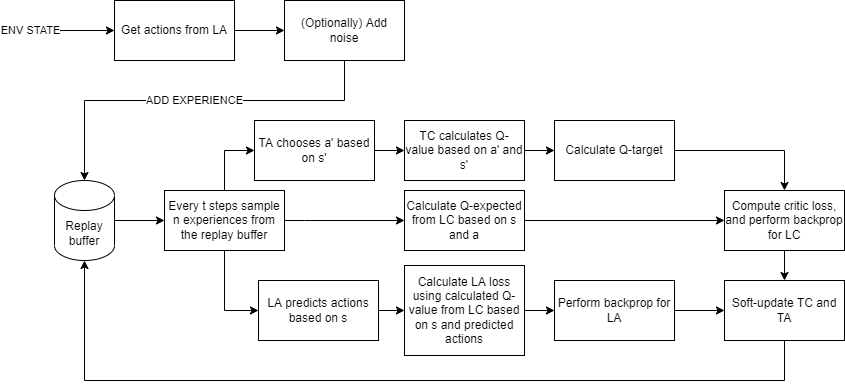

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import json


def plot_scores(vers, title, *param_names):
    legend = []
    score_len = 0
    for v in vers:
        folder = f"training/run{v}"
        df = pd.read_csv(f"{folder}/scores.csv")
        mean_scores = df.mean(axis=1)
        score_len = max(len(mean_scores), score_len)
        mean_scores.plot()
        
        with open(f"{folder}/checkpoint.json", "rb") as json_file:
            params = json.load(json_file)
        legend_entry = ""
        for param_name in param_names:
            legend_entry += f"{param_name[0]}={params[param_name[1]]}; "
        legend.append(legend_entry[:-2])
    plt.plot([0, score_len], [30, 30], 'r--')
    plt.xlim(0, score_len)
    plt.legend(legend)
    plt.title(title)
    plt.ylabel('Score')
    plt.xlabel('Episode #')

# Hyperparameters

Most of the code is reused from the previous exercises (ddpg-pendulum and ddpg-bipedal) and some hyperparameters, like $\gamma$ (discount factor), $\tau$ (update factor for soft-update) and weight decay (for actor network) remained unchanged.

I set buffer size to 1000000 (maximum amount that my RAM could hold) and batch size to 256.

To add variation to actions' values I use normal noise. According to [this article](https://soeren-kirchner.medium.com/deep-deterministic-policy-gradient-ddpg-with-and-without-ornstein-uhlenbeck-process-e6d272adfc3) there is no substantial difference between normal noise and Ornstein-Uhlenbeck Process which was originally used in ddpg-pendulum and ddpg-bipdel. For all my training I used noise scalar value equal 0.25

### $t$ and $n$

$t$ indicates that learning "session" should happen every $t$ steps.

$n$ indicates that we should learn $n$ times during each learning "session".

If we set $t$ low and $n$ high, the learning becomes very unstable. If we do otherwise, the learing is very slow. Below are plots showing agent's learning progress for different values of $t$ and $n$. I found that the optimal values are $t=10, n=20$.

For all below plots: learning rate for actor and critic is 0.001, first hidden layer size is 600, second hidden layer size is 300.

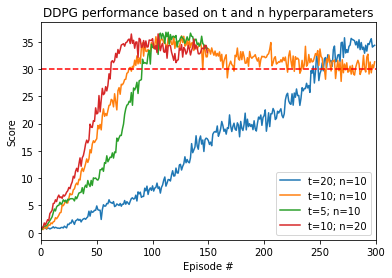

In [27]:
versions = ["v1.0", "v1.1", "v1.2", "v1.3"]
plot_scores(
    versions, "DDPG performance based on t and n hyperparameters", ("t", "learn_every"), ("n", "learn_n_times")
)

### Hidden layers' sizes

Hidden layers' sizes dictate how complex the network should be. The more complex the network is, the more complicated behaviours it can learn. However, it also requires more training and can be prone to overfitting. Smaller networks can often be a better choice because they learn faster. Nevertheless, the network cannot be too small or it won't learn properly. I found the optimal size to be $L1=400$ (first layer of both actor and critic networks) and $L2=200$ (second layer of both networks).

For all below plots: learning rate for actor and critic is 0.001, $t=10$, $n=20$.

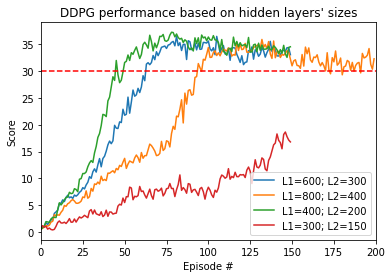

In [30]:
versions = ["v1.3", "v3.0", "v3.1", "v3.2"]
plot_scores(versions, "DDPG performance based on hidden layers' sizes", ("L1", "fc1_units"), ("L2", "fc2_units"))

### Learning rate

Learning rate dictates how much the weights should be changed with each learning step. The higher this rate is, the faster the agent learns. However, high learning rate could lead to unstable learning and divergence. On the other hand, very low learning rate, apart from increasing training time, could also lead to suboptimal solution because we could arrive at some local optimum which is much lower than the global optimum or even some neighbouring local optima. To combat it we can choose an optimizer that uses momentum (e.g. Adam optimizer). I found the optimal learning rate for both networks to be $lr=0.001$

For all below plots, $t=10$, $n=20$, $L1=400$, $L2=200$.

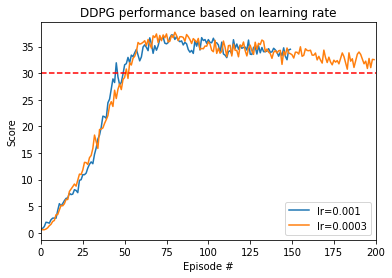

In [31]:
versions = ["v3.1", "v4.0"]
plot_scores(versions, "DDPG performance based on learning rate", ("lr", "lr_actor"))

# Final thoughts and future work

I found that adding $t$ and $n$ hyperparameters (ability to learn $n$ times every $t$ frames), and tuning them properly, made the biggest difference. Another major boost in performance was switching to using smaller model.

For future work I could experiment a bit more with other hyperparameters but I doubt it would make a major impact on the performance. Switching to some newer algorithms, like TRPO or TNPG, could potentially give better results.